In [53]:
%matplotlib inline
def estimate_relative_humidity(q,t_avg,lat,lon):
    ## estimates relative humidity using hypsometric equation for pressure, virtual temperature and 
    ## average temperature 
    import numpy as np
    from xray import ufuncs
    import math 
    from snowpack_functions import get_elev_for_lat_lon,import_gridcell_elevation 
    #################### CONSTANTS ###############################
    Rd = 287.04 ## J kg^-1 K ^-1
    p1 = 100000 ## Pa
    T0 = 273.15 ## Kelvin, reference temperature
    g = 9.81 ## m / s^2
    
    ## need to get elevations for grid cells
    soil_file = '/raid9/gergel/agg_snowpack/soil_avail.txt'
    elev_corr_info = import_gridcell_elevation(soil_file) 
    h = get_elev_for_lat_lon(elev_corr_info,lat,lon)
    
    ##  Tv = T(1 + 0.61w)
    w = q ## approximating the mixing ratio as the specific humidity
    Tv = t_avg * (1 + 0.61*w) 
    ## p = e ^ (-(((z_2 - z_1) * g)/ (Rd*Tv) - ln(p1)))
    hg = h * g
    RdTv = Rd * Tv
    
    #p = ufuncs.exp(-((hg/RdTv) - math.log(p1)))
    p = 101325 * (1 - ((2.25577 * 10**-5) * h))**5.25588 
    print(p)
    print(h)
    ## RH = 0.263*p*q[exp(17.67*T - T0)/(T - 29.65)]^-1
    
    ## using C-C relationship
    e_s = 611 * ufuncs.exp((17.67 * (t_avg - T0)) / (t_avg - 29.65) )
    w_s = 0.622 * (e_s / p)
    RH = 100.0 * (w / w_s)
    
    # RH = 0.263 * p * q * ((ufuncs.exp((17.67 * (t_avg - T0)) / (t_avg - 29.65)))**-1)
    
    return (RH)

def estimate_emc(RH,t):
    if RH < 10: 
        EMC = 0.03229 + (0.281073 * RH) - (0.000578 * t * RH)
    elif RH >= 10 and RH <= 50:
        EMC = 2.22749 - 0.160107*RH - 0.014784*t
    else: 
        EMC = 21.0606 + (0.005565*(RH**2)) - (0.00035*RH*t) - (0.483199*RH)
    return(EMC)

def nfdrs_climate_class(lon):
    ## use eastern boundary of the Cascades to delineate (this might need refinement)
    if lon > -122.5:
        climate_class = 2
        wetrat = 0.25
    else:
        climate_class = 3
        wetrat = 0.05
    return(climate_class,wetrat)


In [54]:
## note this forcing data is for the entire CONUS so i need to mask out what isn't in the CRB 
## note: for masking, ufunc functions can be used directly on a DataArray
%load_ext autoreload
################################# INPUTS #############################
lat = 48.03125
lon = -121.28125
######################################################################
import numpy as np
import xray
from xray import ufuncs
import os
import math 
import gc 
import pandas as pd 
# from dfm_functions import estimate_emc, nfdrs_climate_class,estimate_relative_humidity
basin = "cascades"
model = "CCSM4"
scenario = "historical"

direc = '/raid/gergel/%s' % "tmin"
tmin_file = "%s_%s_%s.nc" % (model,scenario,"tasmin")
tmin_full = xray.open_dataset(os.path.join(direc,tmin_file)) ## load tmin

direc = '/raid/gergel/%s' % "tmax"
tmax_file = "%s_%s_%s.nc" % (model,scenario,"tasmax")
tmax_full = xray.open_dataset(os.path.join(direc,tmax_file)) ## load tmax

direc = '/raid/gergel/%s' % "rh"
sh_file = "%s_%s_%s.nc" % (model,scenario,"huss")
q_full = xray.open_dataset(os.path.join(direc,sh_file)) ## load specific humidity 

direc = '/raid/gergel/%s' % "precip"
pr_file = "%s_%s_%s.nc" % (model,scenario,"pr")
pr_full = xray.open_dataset(os.path.join(direc,pr_file)) ## load precip

## adjust lat/lon dimensions since the index names are different
tmin_lons_new = tmin_full['lon'].values[tmin_full['lon'].values > 180] - 360 
tmin_full['lon'] = tmin_lons_new
tmax_full['lon'] = tmin_lons_new
q_full['lon'] = tmin_lons_new 
pr_full['lon'] = tmin_lons_new

## select out gridcell 
lon_ind = np.where(np.asarray(tmin_full.lon).astype('|S10') == np.str(lon))[0][0]
lat_ind = np.where(np.asarray(tmin_full.lat).astype('|S8') == np.str(lat))[0][0]

## get julian days 
julians = pd.DatetimeIndex(np.asarray(pr_full.time)).dayofyear

# tmin = tmin_full[:,lat_ind,lon_ind]
tmin = tmin_full.isel_points(lon=[lon_ind],lat=[lat_ind])
tmax = tmax_full.isel_points(lon=[lon_ind],lat=[lat_ind])
q = q_full.isel_points(lon=[lon_ind],lat=[lat_ind])
pptamt = pr_full.isel_points(lon=[lon_ind],lat=[lat_ind])


del tmin_full,tmax_full, q_full,pr_full
gc.collect() 

print("sanity check")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sanity check


In [55]:
## relative humidity 
t_avg = (tmin.air_temp_min + tmax.air_temp_max)/2.0
RH = estimate_relative_humidity(q,t_avg,lat,lon)

## estimate vapor pressures
satvpd = ufuncs.exp(1.81 + (((t_avg * 17.27) - 4717.31)/(t_avg - 35.86)))
satvpx = ufuncs.exp(1.81 + (((tmax.air_temp_max * 17.27) - 
                         4717.31)/(tmax.air_temp_max - 35.86)))
satvpn = ufuncs.exp(1.81 + (((tmin.air_temp_min * 17.27) - 
                         4717.31)/(tmin.air_temp_min - 35.86)))
ambvp = (RH * satvpd) * (1.0/100.0)
RHmax = 100.0 * (ambvp/satvpn)
RHmin = 100.0 * (ambvp/satvpx)

## get climate class and rainfall rate 
climat,wetrat = nfdrs_climate_class(lon)
pptamt_in = pptamt * 0.0393701 ## convert from mm to inches 
pptdur = np.round((pptamt/wetrat) + 0.49)
#print(pptdur)

## convert temps to Fahrenheit (this is required for EMC calculations developed by Simard 1968)
# ºF =(K - 273.15)* 1.8000 + 32.00
tmin['air_temp_min'].values = ((tmin.air_temp_min.values - 273.15) * 1.8) + 32.0
tmax['air_temp_max'].values = ((tmax.air_temp_max.values - 273.15) * 1.8) + 32.0
t_avg.values = ((t_avg.values - 273.15) * 1.8) + 32.0

## estimate EMCs
EMCmin = estimate_emc(RHmin,tmax.air_temp_max)
EMC = estimate_emc(RH,t_avg)
EMCmax = estimate_emc(RHmax,tmin.air_temp_min)

phi = lat * 0.01745 ## lat is in degrees 
decl = 0.41008*np.sin((julians-82) * 0.01745)
daylit = 24 * (1.0 - ((np.arccos(np.tan(np.deg2rad(phi)) * np.tan(decl))) / math.pi))

EMCbar = ((daylit * EMCmin) + (24 - daylit) * EMCmax) / 24.0 

bndryh = ((24.0 - pptdur.precipitation) * (EMCbar.specific_humidity + pptdur.precipitation) * 
          (0.5 * pptdur.precipitation + 41.0 ))/24.0 

################################################ calculate 100-hr timelag ######################################## 

## to initialize YMC100 at the beginning of a period
YMC100_0 = 5.0 + (5.0 * climat)

arr_mc100 = np.ndarray(shape=(1,len(julians)),dtype='float')

for day in np.arange(len(julians)):
    if day == 0:
        YMC100 = YMC100_0
    else: 
        YMC100 = arr_mc100[0,day-1]
    arr_mc100[0,day] = YMC100 + (np.float(bndryh[0,day]) - YMC100) * (1.0 - (0.87 * np.exp(-0.24) ) )

87140.4337962
1253.95


In [56]:
# EMCbar

In [57]:
print(np.min(arr_mc100))
print(np.max(arr_mc100))
print(np.mean(arr_mc100))
print(np.std(arr_mc100))

-772720.670164
860.34522506
-9737.37337781
32834.2739965


saving figure to '/raid9/gergel/agg_snowpack/dfm_gridcell'


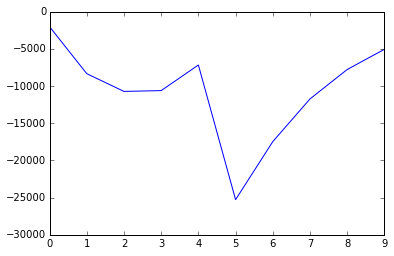

In [64]:
import matplotlib.pyplot as plt
'''ds_dfm = xray.DataArray(arr_mc100)
ds_dfm.time = tmin['time'].values
dfm_sel = ds_dfm.sel(time=slice('1981-02-01', '1981-06-01'))
dfm_sel['dead_fuel_moistue_100hr'].plot()'''
f = 10958 + 366
l = 10958 + 366 + 364
plt.plot(np.asarray(arr_mc100)[0,0:10])

## save plot
direc = '/raid9/gergel/agg_snowpack/'
plotname = 'dfm_gridcell' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)

In [59]:
'''tmin['time'][10958 + 366]
tmin['time'][10958 + 366 + 364]'''
np.asarray(arr_mc100)[0,f:l]

array([ -2.26111155e+05,  -1.54808823e+05,  -1.12133680e+05,
        -8.19833594e+04,  -8.01146114e+04,  -5.45711129e+04,
        -3.72105743e+04,  -4.25707094e+04,  -5.02227929e+04,
        -3.66464258e+04,  -2.89659711e+04,  -2.60482739e+04,
        -2.60131585e+04,  -3.21251114e+04,  -2.37954300e+04,
        -1.60491490e+04,  -1.19471851e+04,  -8.78282614e+03,
        -5.77440337e+03,  -3.69465904e+03,  -8.31946315e+03,
        -6.93088364e+03,  -1.06137286e+04,  -8.42310951e+03,
        -7.90739283e+03,  -5.94970775e+03,  -9.18814886e+03,
        -1.43367801e+04,  -1.05921326e+04,  -7.19165385e+03,
        -4.68100452e+03,  -2.94502418e+03,  -1.76720692e+03,
        -9.89316059e+02,  -1.28087919e+03,  -5.85784197e+02,
        -6.74616274e+02,  -6.40596802e+03,  -1.83937406e+04,
        -1.28996629e+04,  -1.04808951e+04,  -7.11744170e+03,
        -4.72477030e+03,  -3.05843386e+03,  -1.82748794e+03,
        -1.51592788e+03,  -7.83671168e+02,  -5.39860936e+03,
        -7.00167357e+03,

In [62]:
np.mean(RH)

<xray.Dataset>
Dimensions:            ()
Coordinates:
    *empty*
Data variables:
    specific_humidity  float64 67.27